# Subwavelength grating waveguide crossing

The goal of a waveguide crossing is to permit two signals to physically cross or be in close proximity while minimizing mutual interference. It is also desirable for the waveguide crossing to operate across a wide bandwidth and for multiple modes, while having a small physical footprint. In this example, we simulate a waveguide crossing based on a subwavelength grating (SWG) design described in the following paper `B. Ni, H. Xu, C. Luo, S. Wu, and J. Xiong. "Low-loss and broadband silicon-based multimode waveguide crossing at 2 μm using 2-D sub-wavelength holey metamaterials." Optics Express 33, no. 4, p. 6788-6798 (2025).` [DOI:10.1364/OE.550007](https://doi.org/10.1364/OE.550007).

<center><img src="./img/swg_crossing_feature_image.png" alt="SWG crossing schematic" width="400px" /></center>

Subwavelength grating (SWG) structures make use of unit elements whose periodicity $\Lambda$ is much smaller than material optical wavelength $\lambda$. As a result, the optical property of the SWG structure can be described using the effective medium approach. Consider a 1D periodic array of square holes (refractive index $n_1$) embedded in a uniform medium ($n_0$). The fraction (duty cycle) of each unit cell occupied by the medium is $f$ and the fraction occupied by the hole is $(1-f)$. Then, the effective indices of the SWG structure are given by Rytov's equations:

\begin{equation}
  n_{\|} = \left( fn_0^2 + (1-f)n_1^2 \right)^{1/2} 
\end{equation}
\begin{equation}
  n_{\perp} = \left( f/n_0^2 + (1-f)/n_1^2 \right)^{-1/2}
\end{equation}

Here, $n_{\|}$ refers to the effective $n$ for incident light polarized parallel to the hole-medium interface, and $n_{\perp}$ refers to the effective $n$ for incident light polarized orthogonal to the hole-medium interface.

Extending this to 2D, let $f_1, f_2$ be the duty cycles in the horizontal and vertical directions respectively. Then, for a TE mode propagating horizontally, the effective index is given by

\begin{equation}
    n_\text{eff} = \left( f_1 n_0^2 + (1-f_1)[n_\perp^2]_{f=f_2} \right)^{1/2}
\end{equation}

In the SWG waveguide crossing, the goal is to confine an incident signal along its initial direction ("through") while minimizing leakage into the perpendicular direction ("cross"). In other words, we want to engineer the effective refractive index of the crossing such that $n_\text{eff}$ is high along the through direction and low in the cross direction. Consider an example layout shown below.

<center><img src="./img/swg_crossing_1.png" alt="SWG crossing schematic" width="600px" /></center>

The waveguide core index is $n_0 = n_\text{Si} \approx 3.45$ and the hole index $n_1 = n_\text{SiO2} \approx 1.44$. An incident TE mode from the left "sees" $(f_1, f_2) = (0.7, 0.24)$ in region B, $(f_1,f_2) = (0.7,0.7)$ in region C, and $(f_1, f_2) = (0.24, 0.7)$ in region D. The effective $n$ is thus 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
from tidy3d import web

In [2]:
n_si = 3.45
n_sio2 = 1.44
f1 = 0.7
f2 = 0.24


def n_para(f, n0, n1):
    return np.sqrt(f * n0**2 + (1 - f) * n1**2)


def n_perp(f, n0, n1):
    return 1 / np.sqrt(f / n0**2 + (1 - f) / n1**2)


neff_B = n_para(f1, n_si, n_perp(f2, n_si, n_sio2))
neff_D = n_para(f2, n_si, n_perp(f1, n_si, n_sio2))
neff_C = n_para(f1, n_si, n_perp(f1, n_si, n_sio2))

print(f"Effective index in regions B: {neff_B:.3f}, C: {neff_C:.3f}, D: {neff_D:.3f}.")

Effective index in regions B: 3.018, C: 3.131, D: 2.567.


An incident TE mode from region B will be confined in the through direction due to the high $n$ contrast. Since the 2D crossing design has four-fold symmetry, an incident TE mode from region D will likewise be confined in the cross direction.

For practical applications, we also need to introduce a tapered SWG section in order to minimize reflection at the boundary between the input waveguide and the SWG crossing. In the taper section, the duty cycle $f_2$ is gradually ramped down from unity.

<center><img src="./img/swg_crossing_2.png" alt="SWG taper section schematic" width="400px" /></center>

### General Parameters

Defining the general simulation parameters. The paper design explores a relatively wide operational bandwidth ($1.7 - 2.2 \mu$m).

In [3]:
lda_min, lda_max = [1.7, 2.2]  # simulation bandwidth
f_min, f_max = [td.C_0 / lda_max, td.C_0 / lda_min]
run_time = 3e-12  # simulation run time

### Medium

The SWG crossing is composed of the Si core surrounded by SiO2 substrate. Since the bandwidth is relatively broad, we will make use of the dispersive material models from the built-in library.

In [4]:
medium_Si = td.material_library["cSi"]["Palik_Lossless"]
medium_SiO2 = td.material_library["SiO2"]["Palik_Lossless"]

### Geometry And Structure

Key geometry parameters are defined below. We will use design parameters taken from Table 1 in the reference paper. 

In [5]:
thickness = 0.22  # thickness of WG core
W = 3.6  # width of WG core
La = 2  # length of region A
Lb = 2.5  # length of region B
Lin = 2  # length of WG input region
unit_len = 0.25  # dimensions of SWG unit cell

# duty cycles
# suffix '1' or '2' denotes x or y direction; letter denotes region
fa1 = 0.7
fa2min, fa2max = (0.24, 0.72)  # tapered region
fb1, fb2 = (0.7, 0.24)
fc = 0.7  # region C duty cycle is equal in both directions

Within each region, the SWG hole geometries are created using a helper function.

In [6]:
def create_region(position, size, dutyX, dutyY):
    """This helper method creates the unit cell holes for each SWG region."""

    # list of objects to return
    geom_list = []

    # number of elements in each direction
    nx, ny = tuple(map(lambda x: int(x / unit_len), size))

    # initial and final element sizes
    if isinstance(dutyX, tuple):
        L0, L1 = tuple(map(lambda x: unit_len * (1 - x), dutyX))
    else:
        L0, L1 = tuple(map(lambda x: unit_len * (1 - x), (dutyX, dutyX)))
    if isinstance(dutyY, tuple):
        H0, H1 = tuple(map(lambda x: unit_len * (1 - x), dutyY))
    else:
        H0, H1 = tuple(map(lambda x: unit_len * (1 - x), (dutyY, dutyY)))

    # iterate over each direction
    for j in range(ny):
        for i in range(nx):
            xpos = position[0] + (i + 0.5 - 0.5 * nx) * unit_len
            ypos = position[1] + (j + 0.5 - 0.5 * ny) * unit_len
            L = L0 + (i / nx) * (L1 - L0)
            H = H0 + (i / nx) * (H1 - H0)

            geom = td.Box(center=(xpos, ypos, 0), size=(L, H, thickness))
            geom_list.append(geom)

    return geom_list

The simulation structures are defined below - the through WG core, the cross WG core, and the SWG grating holes. 

In [7]:
# Thru WG core structure
structure_WGthru = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, W, thickness)),
    medium=medium_Si,
    name="Core WG Thru",
)

# Cross WG core structure
structure_WGcross = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(W, td.inf, thickness)),
    medium=medium_Si,
    name="Core WG Cross",
)

In [8]:
# SWG holes
geometry_group = []  # store hole geometry objects

# hole specification for each region
region_params = [
    [(-W / 2 - Lb - La / 2, 0), (La, W), fa1, (fa2max, fa2min)],  # region A
    [(-W / 2 - Lb / 2, 0), (Lb, W), fb1, fb2],  # region B
    [(0, 0), (W, W), fc, fc],  # region C
    [(W / 2 + Lb / 2, 0), (Lb, W), fb1, fb2],  # region E (reflection of B)
    [
        (W / 2 + Lb + La / 2, 0),
        (La, W),
        fa1,
        (fa2min, fa2max),
    ],  # region F (reflection of A)
    [(0, W / 2 + Lb / 2), (W, Lb), fb2, fb1],  # region D upper
    [(0, -W / 2 - Lb / 2), (W, Lb), fb2, fb1],  # region D lower
]

# generate regions
for p in region_params:
    geometry_group += create_region(*p)

# create SWG structure based on geometry group
structure_SWG = td.Structure(
    geometry=td.GeometryGroup(geometries=geometry_group),
    medium=medium_SiO2,
    name="SWG grating holes",
)

### Grid And Boundaries

The grid specification is set up below. We make use of mesh override structures to add refinement in the regions with the SWG holes. The grid refinement is based on adding a fictitious material of higher refractive index to the mesh override structures. 

In [9]:
# Mesh override structures
refine_box1 = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(W + 2 * (La + Lb), W, thickness)),
    medium=td.Medium(permittivity=4**2),
)
refine_box2 = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(W, W + 2 * Lb, thickness)),
    medium=td.Medium(permittivity=4**2),
)

# Grid specification
grid_spec = td.GridSpec.auto(
    wavelength=(lda_max + lda_min) / 2,
    min_steps_per_wvl=20,
    override_structures=[refine_box1, refine_box2],
)

Next, the boundary conditions. Because we are using dispersive media, we will use the `Absorber` boundary in the x- and y-directions. (See [this article](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) for further explanation.) We added additional layers to the `Absorber` in the x-direction since that is the primary direction of signal propagation.

In [10]:
# Boundary specification
boundary_spec = td.BoundarySpec(
    x=td.Boundary.absorber(num_layers=60),  # additional layers to absorb through signal
    y=td.Boundary.absorber(),
    z=td.Boundary.pml(),
)

### Mode Source And Monitors

In this demo, we will excite the structure with three modes - TE0, 1, 2. The user-defined `TE_mode_source()` method generates the appropriate `ModeSource` object for the given mode number.

In [11]:
# mode specification
mode_spec = td.ModeSpec(num_modes=3, target_neff=3.45, filter_pol="te")
source_time_spec = td.GaussianPulse(freq0=(f_max + f_min) / 2, fwidth=(f_max - f_min))


# TE mode source generator
def TE_mode_source(mode_num):
    return td.ModeSource(
        center=(-W / 2 - La - Lb - Lin, 0, 0),
        size=(0, 2 * W, 5 * thickness),
        source_time=source_time_spec,
        direction="+",
        mode_spec=mode_spec,
        mode_index=mode_num,
        name="Source TE" + str(mode_num + 1),
    )

The mode source is placed at the left arm of the crossing junction. To monitor the throughput and crosstalk, we will place mode monitors on the right and top arms respectively.

In [12]:
# monitor frequencies
num_freqs = 101
mon_freqs = np.linspace(f_min, f_max, num_freqs)

# mode monitors
mode_monitor_thru = td.ModeMonitor(
    center=(W / 2 + La + Lb + Lin, 0, 0),
    size=(0, 2 * W, 5 * thickness),
    freqs=mon_freqs,
    mode_spec=mode_spec,
    name="Mode Monitor (Thru)",
)
mode_monitor_cross = td.ModeMonitor(
    center=(0, W / 2 + Lb + 0.2, 0),
    size=(2 * W, 0, 5 * thickness),
    freqs=mon_freqs,
    mode_spec=mode_spec,
    name="Mode Monitor (Cross)",
)

We will also include a `FieldMonitor` in the `z=0` plane for field visualization.

In [13]:
field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=(f_max + f_min) / 2,
    name="Field monitor (z=0)",
)

### Setting Up The Simulation Object

To perform a batch sweep over the mode number, we create a dict of the simulation objects.

In [14]:
# Simulation object generator
def TE_sim(mode_num):
    return td.Simulation(
        size=[W + 2 * (La + Lb + Lin) + 0.2, W + 2 * Lb + 0.8, 2.5],
        grid_spec=grid_spec,
        boundary_spec=boundary_spec,
        structures=[structure_WGthru, structure_WGcross, structure_SWG],
        medium=medium_SiO2,
        sources=[TE_mode_source(mode_num)],
        monitors=[mode_monitor_thru, mode_monitor_cross, field_monitor],
        run_time=run_time,
    )


# Create dictionary of sims
# We are sweeping over i=0,1,2 to excite the corresponding TE mode
sim_batch = {f"TE{i}": TE_sim(i) for i in range(3)}

Below, we plot a cross section of the waveguide crossing in the XY-plane. The mode source and monitors are depicted in green and orange respectively.

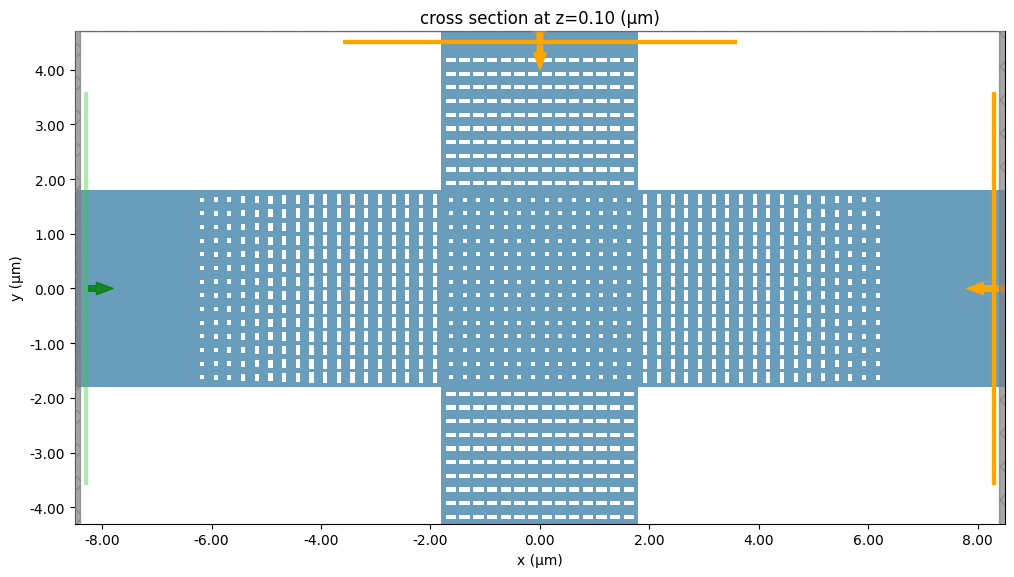

In [15]:
# Sim domain along z=0 plane
hbounds = (-W / 2 - Lb - La - Lin - 0.2, W / 2 + Lb + La + Lin + 0.2)
vbounds = (-W / 2 - Lb, W / 2 + Lb + 0.4)
fig, ax = plt.subplots(figsize=(12, 12))
sim_batch["TE0"].plot(z=0.1, ax=ax, hlim=hbounds, vlim=vbounds, monitor_alpha=1)
plt.show()

We can also preview the simulation setup with the 3D viewer.

In [16]:
sim_batch["TE0"].plot_3d()

We execute the simulation below.

In [17]:
batch = web.Batch(simulations=sim_batch, verbose=True)
batch_results = batch.run(path_dir="swg_crossing_data")

Output()

12:50:29 CEST Started working on Batch containing 3 tasks.

12:50:34 CEST Maximum FlexCredit cost: 4.252 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

12:50:36 CEST Batch complete.

Output()

### Results

In [18]:
# import results
batch = web.Batch.from_file("swg_crossing_data/batch.hdf5")
batch_results = batch.load(path_dir="swg_crossing_data")

The E-field intensities in the z=0 plane are plotted below. We observe clean passage of the desired TE mode with minimal interaction with the cross waveguide.

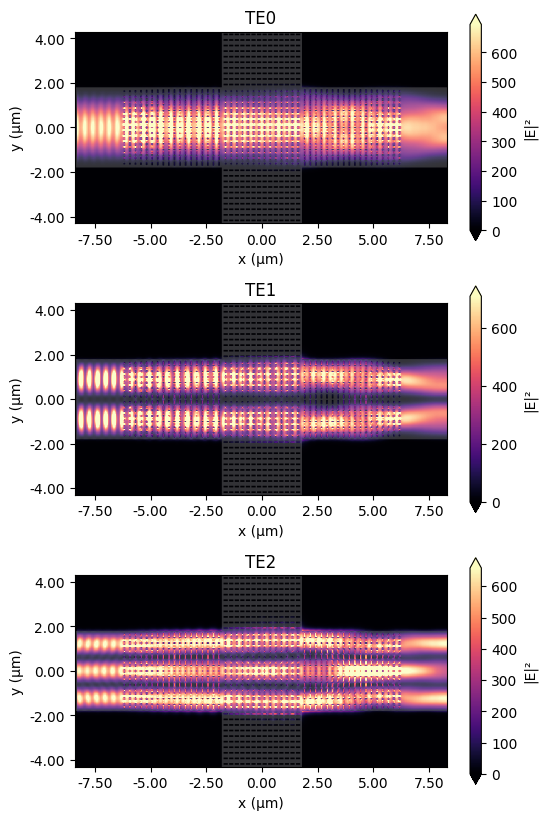

In [19]:
# plotting field data
hbounds = (-W / 2 - Lb - La - Lin - 0.1, W / 2 + Lb + La + Lin)
vbounds = (-W / 2 - Lb, W / 2 + Lb)

fig, ax = plt.subplots(3, 1, figsize=(6, 10))
for i, sim_data in enumerate(batch_results.values()):
    sim_data.plot_field(
        field_monitor_name="Field monitor (z=0)", field_name="E", val="abs^2", ax=ax[i]
    )
    ax[i].set_xlim(*hbounds)
    ax[i].set_ylim(*vbounds)
    ax[i].set_title("TE" + str(i))

plt.show()

We can quantify the performance of the crossing by looking at the transmitted mode amplitude (dB) data in the through and cross mode monitors.

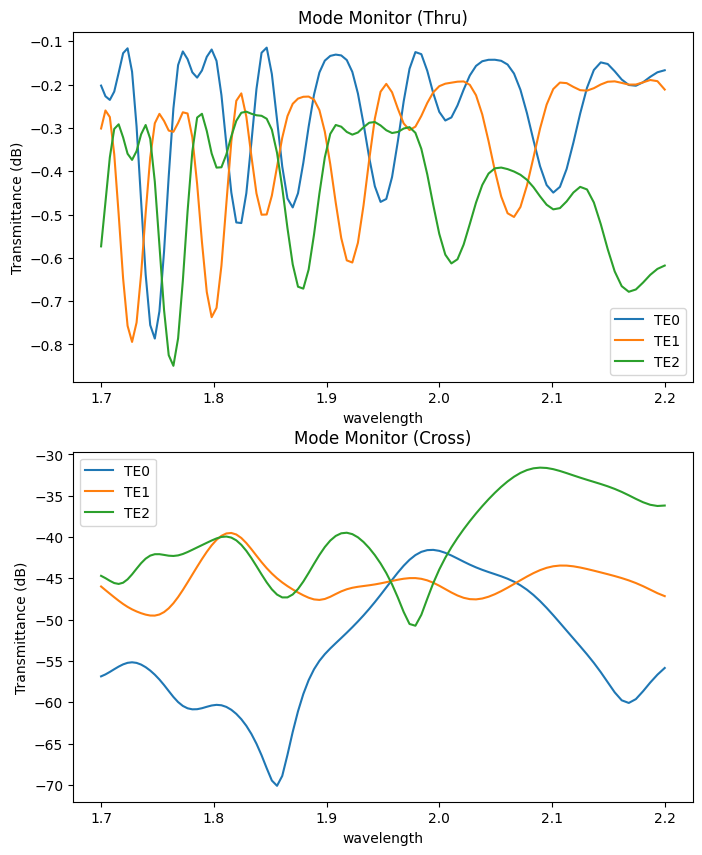

In [20]:
avg_tr = np.zeros((2, 3))  # average transmission

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
for i, sim_data in enumerate(batch_results.values()):
    for j, mon in enumerate(["Mode Monitor (Thru)", "Mode Monitor (Cross)"]):
        mode_data = sim_data[mon].amps.sel(
            mode_index=i, direction="+"
        )  # access mode transmission data
        mode_data = mode_data.assign_coords(
            wavelength=td.C_0 / mode_data.f
        )  # add coordinates for wavelength
        avg_tr[j, i] = np.average(np.abs(mode_data) ** 2)  # calculate average transmittance
        db_data = 20 * np.log10(np.abs(mode_data))  # convert to db scale

        # plotting
        db_data.plot(x="wavelength", ax=ax[j], label="TE" + str(i))
        ax[j].set_title(mon)
        ax[j].set_ylabel("Transmittance (dB)")
        ax[j].legend()

plt.show()

In [21]:
avg_tr_db = 10 * np.log10(avg_tr)
print(
    f"Average transmittance (dB) for through mode, TE0: {avg_tr_db[0, 0]:.3f}, TE1: {avg_tr_db[0, 1]:.3f}, TE2: {avg_tr_db[0, 2]:.3f}"
)
print(
    f"Average transmittance (dB) into cross mode, TE0: {avg_tr_db[1, 0]:.3f}, TE1: {avg_tr_db[1, 1]:.3f}, TE2: {avg_tr_db[1, 2]:.3f}"
)

Average transmittance (dB) for through mode, TE0: -0.269, TE1: -0.343, TE2: -0.436
Average transmittance (dB) into cross mode, TE0: -48.640, TE1: -44.789, TE2: -37.736


We observe excellent through mode confinement and cross mode rejection across the entire operational bandwidth.